In [1]:
print("start importing")
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import sys
import random
from matplotlib import ticker
from torchvision import datasets, transforms
sys.path.append('../../')
from src.datasets.zipf import get_zipf_probs, get_dataset_samples, ZipfOnlineDatasetLoader
from src.models.frequency.sketch_algorithms import SketchQueryalgorithms
from src.datasets.read_data import load_data
device = 'cuda:0'
class_read_data = load_data()

start importing


In this notebook we fix the sketch size to a number, and try several combinations of d (num linear projection) and w (dim linear projection) (d*w=sketch size) several times with 3 datasets with bloom filter algorithm.
We try to fix the sketch size to 10% and 1% of the input dimension of the dataset.

## Bloom flilter

In [2]:
def bloom_filter(list_w,list_d,n_dims):
    """
    This function computes the bloom filter for different d and w several times, and returns a matrix with the losses of several runs and different d and w.
    """
    num_samples = 10
    runs = 10
    space_alpha = [0.2,0.5,1.0,1.5]
    err_bf = np.zeros([runs,len(space_alpha),len(list_w)])
    for run in range(runs):
        beta = 0.5
        iter_alpha = 0
        for alpha in space_alpha:
            # Generating dataset 
            zipfdatasetloader = ZipfOnlineDatasetLoader(500, n_dims, num_samples, alpha_min=alpha, alpha_max=alpha,beta_min=beta, beta_max=beta,device=device)

            errors_bf = []
            # For each d and w
            for i in range(len(list_w)):
                w = list_w[i]
                d = list_d[i]
                # Compute bloom filter
                bloom_filter = SketchQueryalgorithms(n_dims, w, d,'BF')
                err = []
                # Iterate the batches and take just the first batch
                for j, (x,y) in enumerate(zipfdatasetloader):
                    if j == 0:     
                        for batch in range(x.shape[0]):
                            x_i = x[batch].cpu()
                            y_i = y[batch].cpu()

                            # If the mean > 1, the feature is in the dataset
                            y_i[y_i==0]=0
                            y_i[y_i>0] = 1
                            # Compute BF
                            y_hat, s = bloom_filter.SketchQuery_algorithms(x_i)
                            error = torch.mean(torch.square(torch.clamp(y_hat, 0, 1)-y_i.squeeze()))
                            err.append(error.item())
                        errors_bf.append(np.mean(err))

            err_bf[run,iter_alpha,:] = errors_bf
            iter_alpha += 1
    return err_bf,space_alpha

            
            

In [3]:
def ds_reshape( ds, dim1, dim2 ):
    """
    Reshapes the dimensions of the data to add the batch size dim (Batch_size x num_samples x num_features)
    The input parameters are the data, dim1 (batch_size) and dim2 (num_samples)
    If dim1*dim2 is bigger than the number of rows of the datasets, an error will be printed
    If dim1*dim2 is smaller than the number of rows, data will be trimmed and will have the following dimensions:(Batch_size x num_samples x num_features) 
    If dim1*dim2 is equal to the number of rows, data will have the following dimensions:(Batch_size x num_samples x num_features) 
    """ 
    assert( dim1*dim2 <= ds.shape[0] )
    if  dim1*dim2 < ds.shape[0]:
        print('Warning: data will be trimmed')
        return ds[:dim1*dim2].reshape( (dim1, dim2, ds.shape[1] )) 
    else:
        return ds.reshape( ( dim1, dim2, ds.shape[1] ))

In [17]:
def bloom_filter_other_datasets(list_w,list_d,n_dims,path,name_dataset):
    """
    This function computes the bloom filter for different d and w several times, and returns a matrix with the losses of several runs and different d and w.
    """
    num_samples = 10
    runs = 5
    err = np.zeros([runs,len(list_w)])
    metric = torch.square
    
    data_train,data_val,data_test = class_read_data.loaddata(path)
  
    # reshape data to have batch, num_samples and features (Bx500x1000)
    if name_dataset == 'dogs':
        x = ds_reshape( data_train,  int(data_test.shape[0]/62), 62 )
    else:
        x = ds_reshape( data_train,  int(data_test.shape[0]/num_samples), num_samples)    
    
    y = torch.mean(x.float(), dim=1)
    y[y == 0] = 0
    y[y > 0] = 1        
    
    for run in range(runs):
        # Compute the algorithm for each combination
        errors_bf = []
        for i in range(len(list_w)):
            w = list_w[i]
            d = list_d[i]
            bloom_filters = SketchQueryalgorithms(n_dims, w, d,'BF')
            
            error_BF = []       
            for batch in range(x.shape[0]):
                x_i = x[batch].cpu()
                y_i = y[batch].cpu()
                # Compute BF
                y_hat, s = bloom_filters.SketchQuery_algorithms(x_i)
                error = torch.mean(metric(torch.clamp(y_hat, 0, 1)-y_i.squeeze()))
                error_BF.append(error.item()) 

            errors_bf.append(np.mean(error_BF))       
        err[run,:] = errors_bf
    
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    
    # Log scale in the x axis
    ax.set_xscale('symlog')
    ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
    ax.set_yscale('symlog')
    ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
    # Compute mean
    mean_steps = np.nanmean(err, axis=0)
    # Compute std
    std_steps = np.nanstd(err, axis=0) 
    plt.errorbar(list_w, mean_steps, yerr = std_steps, fmt = 'o',color = 'orange', 
                ecolor = 'orange',markeredgewidth=1,label='W',elinewidth = 1,ls='dashed') #, elinewidth = 1, capsize=10

    plt.errorbar(list_d, mean_steps, yerr = std_steps, fmt = '-o',color = 'orange', 
                ecolor = 'orange',markeredgewidth=1,label='D',elinewidth = 1) #, elinewidth = 1, capsize=10

    plt.legend()
    plt.title("Evolution of the MSE Loss")
    plt.xlabel("w or d")
    plt.ylabel("MSE loss")
    plt.show()
    plt.close()           
    
    return err

            
            

In [7]:
def MSE_plot(list_w,list_d,err_bf,space_alpha):
    """
    This function plots the evolution mean and std of the MSE error for the different runs and different combinations of d and w.
    """
    x_3 = 0
    # Compute mean
    mean_steps = np.nanmean(err_bf, axis=0)
    # Compute std
    std_steps = np.nanstd(err_bf, axis=0) 
    fig = plt.figure(figsize=(11, 8)) 
    for i in range(len(space_alpha)):
        x_3 += 1
        ax = fig.add_subplot(2,2,x_3)

        # Log scale in the x axis
        ax.set_xscale('symlog')
        ax.xaxis.set_major_formatter(ticker.ScalarFormatter())
        ax.set_yscale('symlog')
        ax.yaxis.set_major_formatter(ticker.ScalarFormatter())
        plt.errorbar(list_w, mean_steps[i], yerr = std_steps[i], fmt = 'o',color = 'orange', 
                    ecolor = 'orange',markeredgewidth=1,label='W BF',ls='dashed',elinewidth = 1) #, elinewidth = 1, capsize=10

        plt.errorbar(list_d, mean_steps[i], yerr = std_steps[i], fmt = '-o',color = 'orange', 
                    ecolor = 'orange',markeredgewidth=1,label='D BF',elinewidth = 1) #, elinewidth = 1, capsize=10

        #plt.title("Evolution of the MSE Loss")
        plt.title("Beta 0.5, Alpha {}".format(space_alpha[i]),fontsize=10)
        plt.xlabel("w or d")
        plt.ylabel("MSE loss")
        plt.xticks(fontsize=8)
        plt.yticks(fontsize=8)
    plt.legend(loc='center left', bbox_to_anchor=(1, 2.1))
    # set the spacing between subplots
    plt.subplots_adjust(left=0.1,
                        bottom=0.1, 
                        right=0.9, 
                        top=0.9, 
                        wspace=0.4, 
                        hspace=0.25)
    # Save plot if sketch size is 100
    if list_w[0]*list_d[0]==100:
        plt.savefig('../../results/plots_CM_CS_BF/Bloomfilter_MSE_dw_sk100', bbox_inches='tight')
    plt.show()
    plt.close()  


# Zipf dataset

## Sketch size = d * w = 100 (10% input dimention)

In [9]:
## Generating dataset
n_dims = 1000 # Input dimention

# Define the combination of w and d parameters
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

loss,space_alpha = bloom_filter(list_w,list_d,n_dims)

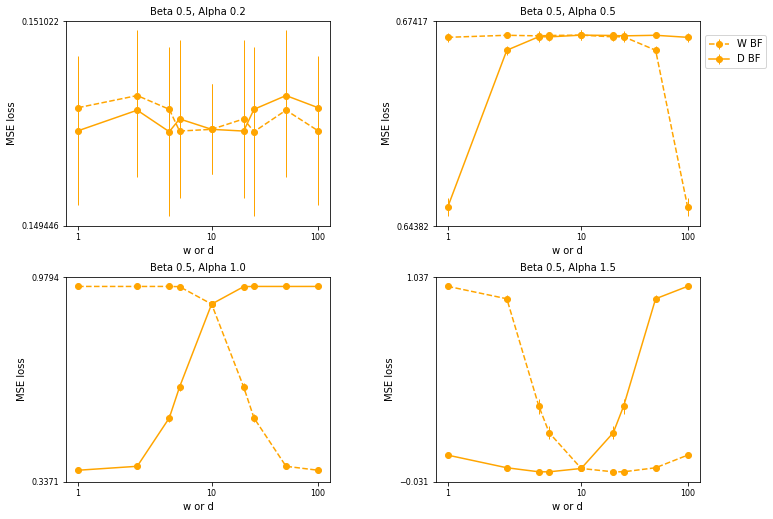

In [8]:
MSE_plot(list_w,list_d,loss,space_alpha)

## Sketch size = d * w = 10 (1% input dimention)

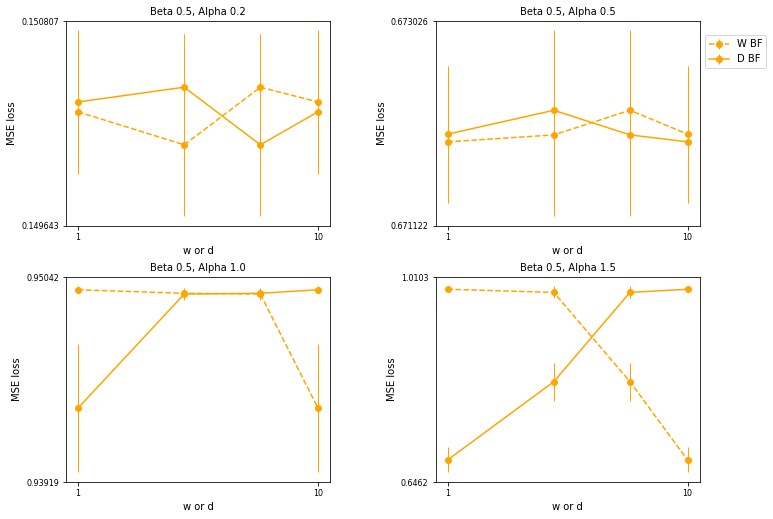

In [10]:
## Generating dataset
n_dims = 1000 # Input dimention


# Define the combination of w and d parameters
list_w = [1,2,5,10]
list_d = [10,5,2,1] 

loss,space_alpha = bloom_filter(list_w,list_d,n_dims)
MSE_plot(list_w,list_d,loss,space_alpha)

# Genetics dataset

## Sketch size = d * w = 100 (input dimention)

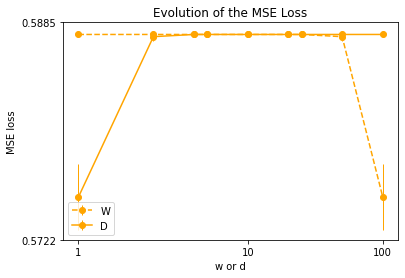

In [18]:
## Creating count-min sketch
n_dims = 1000

# Define the combination of w and d parameters
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 


loss = bloom_filter_other_datasets(list_w,list_d,n_dims,'../../results/datasets/datasets_sketch/humans.npz','humans')



## Sketch size = d * w = 10 (1 % input dimention)

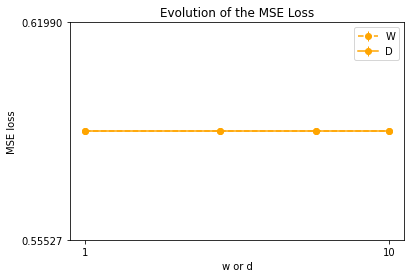

In [19]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,5,10]
list_d = [10,5,2,1] 

loss = bloom_filter_other_datasets(list_w,list_d,n_dims,'../../results/datasets/datasets_sketch/humans.npz','humans')


# MNIST dataset

## Sketch size = d * w = 100 (10 % input dimention)

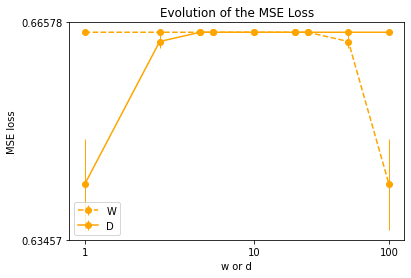

In [20]:
## Creating count-min sketch
n_dims = 1000

# Define the combination of w and d parameters
list_w = [1,2,4,5,10,20,25,50,100] 
list_d = [100,50,25,20,10,5,4,2,1] 

loss = bloom_filter_other_datasets(list_w,list_d,n_dims,'../../results/datasets/datasets_sketch/MNIST.npz','MNIST')



## Sketch size = d * w = 10 (1 % input dimention)

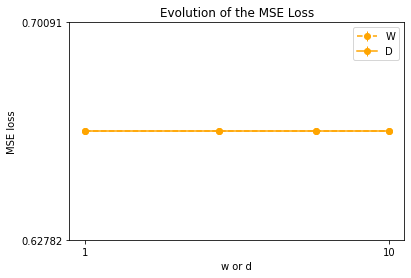

In [21]:
## Creating count-min sketch
n_dims = 1000

list_w = [1,2,5,10]
list_d = [10,5,2,1] 

loss = bloom_filter_other_datasets(list_w,list_d,n_dims,'../../results/datasets/datasets_sketch/MNIST.npz','MNIST')

